In [1]:
%load_ext autoreload

## Import modules

In [21]:
from pathlib import Path

import numpy as np
import scipy
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from qnet.model import Model

from workshop.common import CarUnit
from workshop.model import CarUnitModelMetrics
from main import get_simulation_model, collect_model_metrics, run_simulation

## Simulation time

### Config

In [3]:
plots_path = Path('plots/')
collect_step_time = 100
num_runs = 20
simulation_time = 150_000
end_time = 200_000

### Collect metrics

In [6]:
runs_metrics = Parallel(n_jobs=-1, backend='multiprocessing')(
    delayed(collect_model_metrics)(model=get_simulation_model(first_repair_priority=False).dumps(),
                                   metric_name='repair_wait_time_mean',
                                   start_time=0,
                                   end_time=end_time,
                                   collect_step_time=collect_step_time) for _ in range(num_runs))

### Analysis

[Text(0.5, 0, 'Simulation time'),
 Text(0, 0.5, 'Total wait time before repairs')]

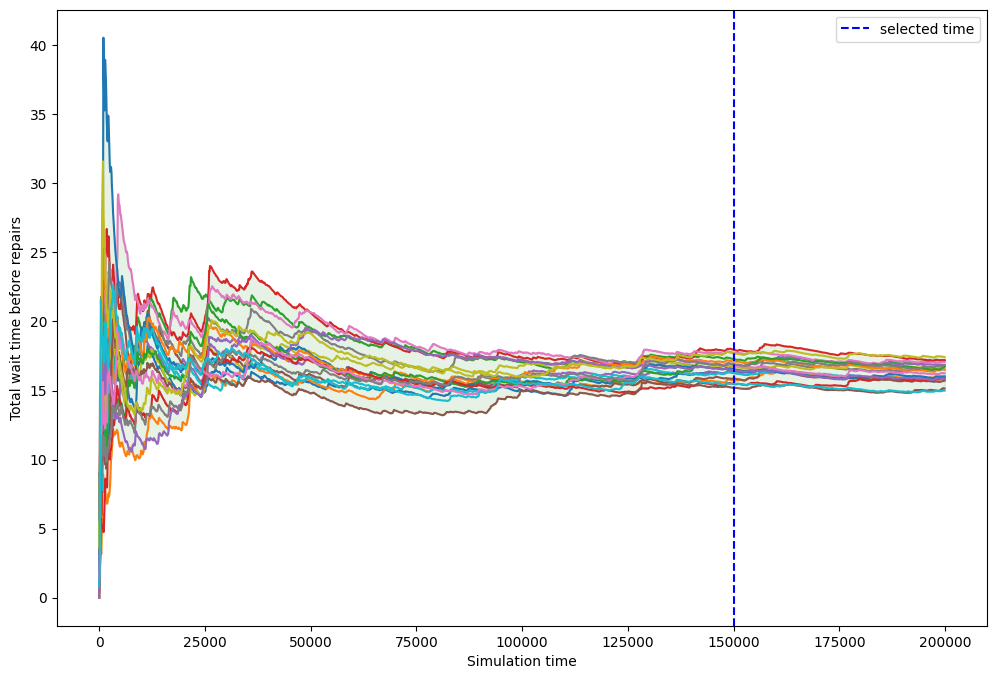

In [7]:
time_steps = np.arange(0, end_time, collect_step_time)
runs_metrics = np.asarray(runs_metrics)

fig, ax = plt.subplots(figsize=(12, 8))

ax.fill_between(time_steps, runs_metrics.min(axis=0), runs_metrics.max(axis=0), color='green', alpha=0.1)
for idx in range(num_runs):
    ax.plot(time_steps, runs_metrics[idx])
ax.axvline(simulation_time, linestyle='--', color='blue', label='selected time')

ax.legend(loc='upper right')
ax.set(xlabel='Simulation time', ylabel='Total wait time before repairs')
# fig.savefig(plots_path.joinpath('simulation_time_2.png'), dpi=300)

## Analysis of variance

### Config

In [24]:
alpha = 0.05

### Collect metrics

In [8]:
first_metrics = Parallel(n_jobs=-1, backend='multiprocessing')(
    delayed(run_simulation)(model=get_simulation_model(first_repair_priority=True).dumps(),
                            metric_name='repair_wait_time_mean',
                            simulation_time=simulation_time) for _ in range(num_runs))

second_metrics = Parallel(n_jobs=-1, backend='multiprocessing')(
    delayed(run_simulation)(model=get_simulation_model(first_repair_priority=False).dumps(),
                            metric_name='repair_wait_time_mean',
                            simulation_time=simulation_time) for _ in range(num_runs))

### Analysis

In [9]:
metrics = np.asarray([first_metrics, second_metrics])

In [31]:
num_factors, num_runs = metrics.shape
rest_deg = num_factors - 1
factor_deg = num_factors * (num_runs - 1)
factors_means = metrics.mean(axis=1, keepdims=True)
mean = factors_means.mean()
d_rest = num_runs * np.square(factors_means - mean).mean() / rest_deg
d_factor = np.square(metrics - factors_means).sum() / factor_deg
f_exp = d_rest / d_factor
f_critical = scipy.stats.f.ppf(1 - alpha, rest_deg, factor_deg)

In [41]:
print(f'''
Rest degrees of freedom: {rest_deg}
Factor degrees of freedom: {factor_deg}
Mean: {mean:.3f}
Factors means: {factors_means[0, 0]:.3f} and {factors_means[1, 0]:.3f}
F experimental: {f_exp:.3f}
F critical: {f_critical:.3f}
Factors have {'negligible' if f_exp < f_critical else 'significant'} effect
''')


Rest degrees of freedom: 1
Factor degrees of freedom: 38
Mean: 16.516
Factors means: 16.268 and 16.763
F experimental: 1.248
F critical: 4.098
Factors have negligible effect

